In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['image.origin'] = 'lower'
import os
import sys
package_path  = os.path.abspath('..')
sys.path.insert(0, package_path)


In [2]:
from scipy import sparse as sps

In [3]:
from ccorr import wnanmean, cCorrNormedW, quadfit, calc_ellipse_scale2

In [4]:
cCorrNormedW?

Signature:     
cCorrNormedW(
    im,
    temp_vec,
    vartemp,
    cols,
    rows,
    mask,
    max_disp=30,
    cx=0,
    cy=0,
)
Call signature: cCorrNormedW(*args, **kwargs)
Type:           fused_cython_function
String form:    <cyfunction cCorrNormedW at 0x11f045e40>
Docstring:     
Calculate cross-correlation between image and template, in a limited ROI of displacement k. This is the bad-pixel-tolerant version of cv.TM_CCORR_NORMED [See: https://docs.opencv.org/4.x/df/dfb/group__imgproc__object.html#gga3a7850640f1fe1f58fe91a2d7583695dac6677e2af5e0fae82cc5339bfaef5038], and in order to be able to handle NAN on the bad pixels, I have to abandon FFT and do the convolution in the image space.

Parameters:
np.ndarray[double, ndim=2] im: the image, must be 2D
np.ndarray[double, ndim=1] temp_vec: the vectorized template. For efficiency, it's required to be (a) vectorized into 1D using the sparse_coo mask represented with cols and rows, and (b) offset such that the (potentially weighte

In [5]:
from benchmark import gen_mask, prep_data, blemish, cm2extent
from benchmark import display_data, visualize_fitres

## Make two Masks
1. One for the bad pixels, to be applied to the template and image;
2. Another to specify the pixels of interest on the template.

In [6]:
disp = [-3,-1]
temp, im = prep_data(200,disp, False)

In [7]:
artifacts = [(np.s_[115:125,115:125], 1), ]
badpxs    = [np.s_[138:143, 118:123], ]
all_badpxs = badpxs + [p[0] for p in artifacts]
tempb = blemish(temp, artifacts, badpxs)
imb = blemish(im, artifacts, badpxs)

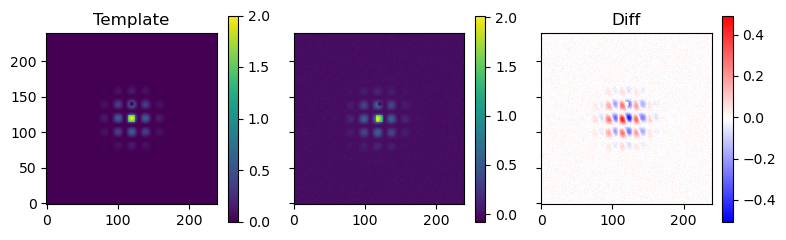

In [8]:
f1, _ = display_data(tempb, imb)

In [9]:
mask_coo = gen_mask(100, temp)
for roi in all_badpxs:
    mask_coo[roi] = 0
mask_coo = sps.coo_matrix(mask_coo)

In [10]:
for roi in all_badpxs:
    imb[roi] = np.nan
    tempb[roi] = np.nan
temp_vec = tempb[mask_coo.row, mask_coo.col]
temp_vec-= wnanmean(temp_vec, mask_coo.data)
temp_var = wnanmean(temp_vec**2, mask_coo.data)

In [11]:
res_custom = cCorrNormedW(imb, temp_vec, temp_var,
                         mask_coo.col, mask_coo.row, mask_coo.data, max_disp=20)

Text(0.5, 1.0, 'max@(-2.97,-1.00)')

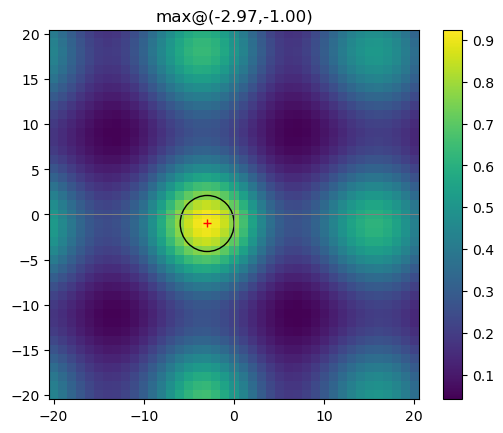

In [12]:
m = res_custom
plt.imshow(m, extent=cm2extent(m))
plt.colorbar()
fitout = quadfit(m, rk=2)
visualize_fitres(fitout, s2=1)
plt.title("max@(%.2f,%.2f)"%tuple(fitout['k*']))